# Detección de Fugas en Sistemas de Distribución de Agua usando Espectrogramas Logarítmicos

## 1. Importación de Librerías

In [1]:
# Importación de la clase WaveletDenoising
!pip install PyWavelets
!pip install --upgrade numpy
!pip install tensorflow==2.12.0
!pip install larq==0.14.0


  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
larq 0.13.3 requires numpy<2.0,>=1.15.4, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
orbax-checkpoint 0.11.9 requires jax>=0.5.0, but you have jax 0.4.30 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.12.0 which is incompatible.
nibabel 5.3

ERROR: Could not find a version that satisfies the requirement larq==0.14.0 (from versions: 0.1.1, 0.2.0, 0.3.0, 0.4.0, 0.5.0, 0.6.0, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.7.4, 0.8.0, 0.8.1, 0.8.2, 0.8.3, 0.8.4, 0.9.0, 0.9.1, 0.9.2, 0.9.3, 0.9.4, 0.9.5, 0.9.6, 0.10.0, 0.10.1, 0.10.2, 0.10.3, 0.11.0, 0.11.1, 0.11.2, 0.12.0, 0.12.1, 0.12.2, 0.13.0, 0.13.1, 0.13.2, 0.13.3)
ERROR: No matching distribution found for larq==0.14.0


In [9]:
import pywt
from denoising import WaveletDenoising
import larq as lq
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [3]:
# Importación de librerías necesarias
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal

import seaborn as sns
import h5py
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

In [4]:

# Para montar Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Cargar y Visualizar Datos

Data Directory: /content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched
Sample Rate: 25600 Hz
Classification Mode: five_classes
Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


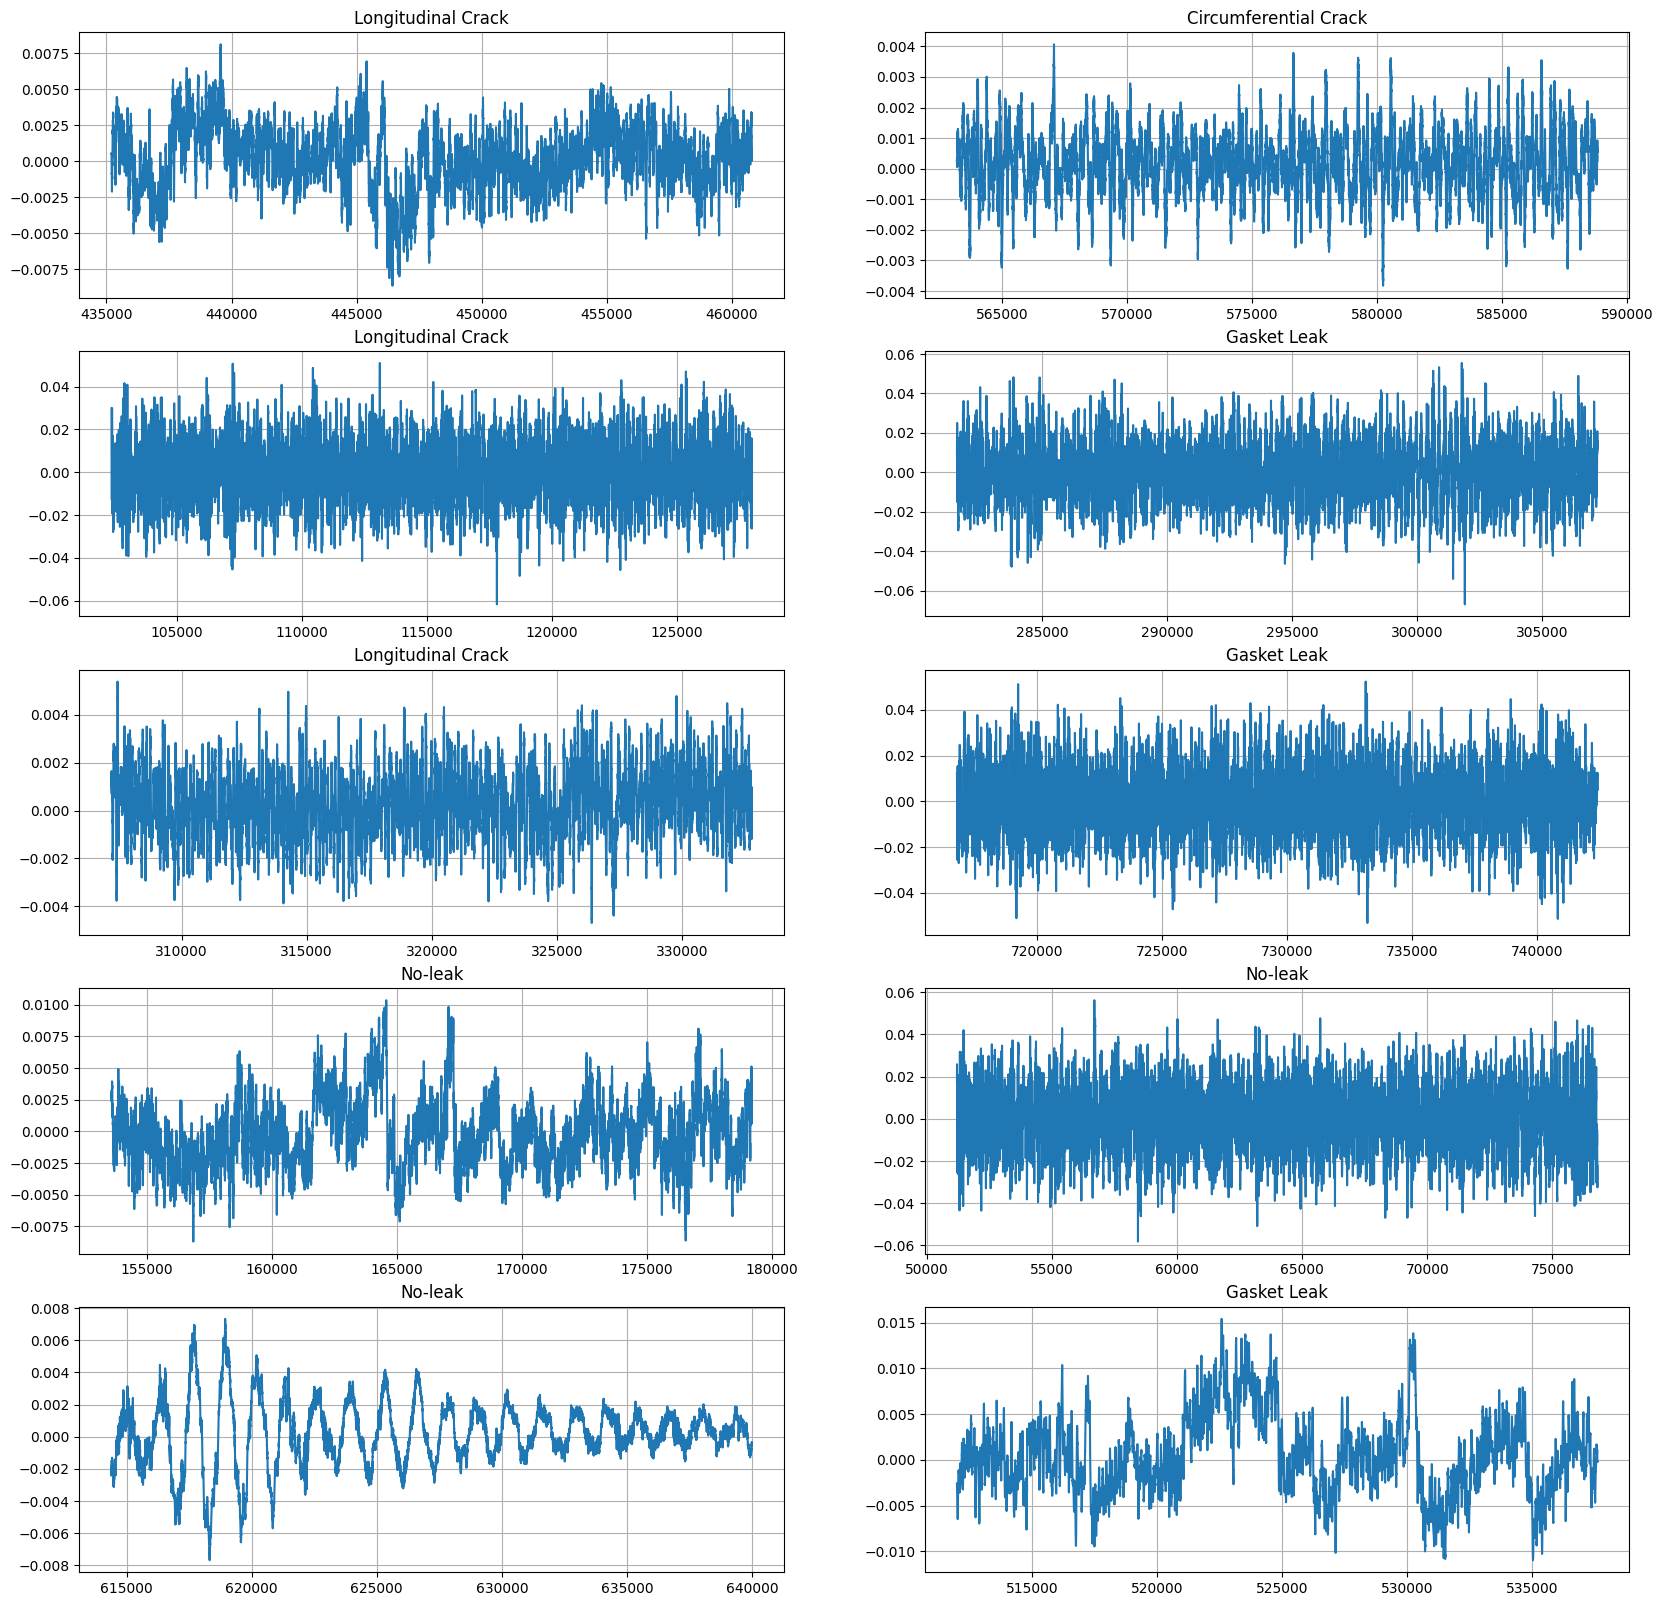

In [5]:
# Cambiando la ruta para acceder a los datos en Google Drive
data_dir = '/content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched'
original_sr = 25600  # in Hz
signal_sr = 25600  # in Hz
downsample_factor = original_sr//signal_sr

# Modo de clasificación: 'five_classes' o 'binary'
classification_mode = 'five_classes'  # Cambiar según necesidad

# Definir diccionarios de etiquetas según el modo de clasificación
if classification_mode == 'five_classes':
    label_codes_dict = {'Circumferential Crack': 0, 'Gasket Leak': 1, 'Longitudinal Crack': 2, 'No-leak': 3, 'Orifice Leak': 4}
else:  # binary
    label_codes_dict = {'Leak': 0, 'No-leak': 1}

# Esta función elimina el archivo .DS_Store si existe en la ruta definida
def remove_DS_store_file(path):
    # Buscar tanto .DS_Store como .DS_store (diferencias de capitalización)
    for ds_name in ['.DS_Store', '.DS_store']:
        ds_store_file_location = os.path.join(path, ds_name)
        if os.path.isfile(ds_store_file_location):
            os.remove(ds_store_file_location)

def load_accelerometer_data(data_dir, sample_rate, downsample_factor, label_codes, mode='five_classes', fraction_to_include=1):
    """
    Carga datos de acelerómetro con opción para clasificación binaria o multiclase

    Args:
        data_dir: Directorio donde se encuentran los datos
        sample_rate: Tasa de muestreo deseada
        downsample_factor: Factor de submuestreo
        label_codes: Diccionario de códigos de etiquetas
        mode: 'five_classes' o 'binary'
        fraction_to_include: Fracción de frames a incluir

    Returns:
        signals: Lista de señales
        labels: Lista de etiquetas
    """
    # Eliminar .DS_Store si existe en data_dir
    remove_DS_store_file(data_dir)

    signals = []
    labels = []

    # Para el modo binario, necesitamos contabilizar cuántos frames hay por cada tipo de fuga
    leak_counts = {
        'Circumferential Crack': 0,
        'Gasket Leak': 0,
        'Longitudinal Crack': 0,
        'Orifice Leak': 0
    }
    leak_signals = {
        'Circumferential Crack': [],
        'Gasket Leak': [],
        'Longitudinal Crack': [],
        'Orifice Leak': []
    }
    no_leak_signals = []
    no_leak_labels = []

    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)

        # Verificar que sea un directorio antes de procesarlo
        if not os.path.isdir(label_dir):
            print(f"Omitiendo {label_dir} porque no es un directorio")
            continue

        # Eliminar .DS_Store si existe
        remove_DS_store_file(label_dir)

        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)

            # Verificar que sea un archivo
            if not os.path.isfile(file_path):
                continue

            # Cargar el archivo csv
            accelerometer_signal_df = pd.read_csv(file_path, index_col=False)

            # Submuestrear seleccionando cada n-ésima fila
            accelerometer_signal_df = accelerometer_signal_df.iloc[::downsample_factor, :]
            accelerometer_signal_df = accelerometer_signal_df.reset_index(drop=True)

            # Obtener 30 segundos de datos
            accelerometer_signal = accelerometer_signal_df['Value'][0:(sample_rate*30)]

            # Generar un vector con el índice de inicio para cada frame de 1 segundo
            sample_indexes = np.linspace(0,len(accelerometer_signal)-sample_rate,len(accelerometer_signal)//sample_rate)

            # Obtener el número de frames de señal
            signal_frames_number = fraction_to_include*len(sample_indexes)
            signal_frames_counter = 0

            # Generar frames de señal de 1 segundo a partir de la señal original
            for signal_frame in sample_indexes:
                accelerometer_signal_frame = accelerometer_signal[int(signal_frame):int(signal_frame+sample_rate)]
                signal_frames_counter+=1

                if signal_frames_counter > signal_frames_number:
                    break

                if len(accelerometer_signal_frame) != sample_rate:
                    continue

                if mode == 'five_classes':
                    # Guardar directamente para clasificación de 5 clases
                    signals.append(accelerometer_signal_frame)
                    labels.append(label_codes[label])
                else:  # modo binario
                    # Para modo binario, guardamos las señales según su tipo
                    if label == 'No-leak':
                        no_leak_signals.append(accelerometer_signal_frame)
                        no_leak_labels.append(1)  # 1 para No-leak en modo binario
                    else:
                        # Guardar en la categoría correspondiente
                        leak_signals[label].append(accelerometer_signal_frame)
                        leak_counts[label] += 1

    # Si estamos en modo binario, equilibramos el dataset
    if mode == 'binary':
        # Encontrar la cantidad mínima de ejemplos por tipo de fuga
        min_count_per_leak_type = min(leak_counts.values()) if leak_counts else 0

        # Calcular cuántos ejemplos necesitamos de cada tipo para equilibrar con No-leak
        if len(no_leak_signals) > 0 and len(leak_counts) > 0:
            total_leak_samples_needed = len(no_leak_signals)
            samples_per_leak_type = total_leak_samples_needed // len(leak_counts)

            # Asegurar que no tomamos más muestras de las disponibles
            samples_per_leak_type = min(samples_per_leak_type, min_count_per_leak_type)

            # Seleccionar muestras equilibradas de cada tipo de fuga
            balanced_leak_signals = []
            for leak_type in leak_signals:
                if leak_signals[leak_type]:
                    # Tomar una muestra aleatoria del tamaño necesario
                    selected_signals = random.sample(leak_signals[leak_type],
                                                    min(samples_per_leak_type, len(leak_signals[leak_type])))
                    balanced_leak_signals.extend(selected_signals)

            # Crear etiquetas para las señales de fuga (0 para Leak en modo binario)
            balanced_leak_labels = [0] * len(balanced_leak_signals)

            # Combinar todo
            signals = balanced_leak_signals + no_leak_signals
            labels = balanced_leak_labels + no_leak_labels

            print(f"Modo binario: {len(balanced_leak_labels)} muestras de fuga, {len(no_leak_labels)} muestras sin fuga")

    return signals, labels

# Cargar los datos desde Google Drive
signals_lst, labels_lst = load_accelerometer_data(
    data_dir,
    signal_sr,
    downsample_factor,
    label_codes_dict,
    mode= classification_mode,
    fraction_to_include=1
)

signals_dict = {'training': [], 'testing': []}
labels_dict = {'training': [], 'testing': []}

# Generar diccionarios con subconjuntos de entrenamiento y prueba a partir de los datos cargados
signals_dict['training'], signals_dict['testing'], labels_dict['training'], labels_dict['testing'] = train_test_split(
    signals_lst,
    labels_lst,
    test_size=0.2,
    random_state=53
)

# Imprimir información sobre el dataset resultante:
print(f'Data Directory: {data_dir}')
print(f'Sample Rate: {signal_sr} Hz')
print(f'Classification Mode: {classification_mode}')
print(f'Number of signals (training, testing): ({len(signals_dict["training"])}, {len(signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(signals_dict["training"][np.random.randint(0,len(signals_dict["training"]))])}')

# Graficar algunas de las señales resultantes
plt.figure(figsize=(20, 20))
rows = 5
cols = 2
n = rows * cols
random_index = []

for i in range(n):
    plt.subplot(rows, cols, i+1)
    random_index.append(np.random.randint(0, len(signals_dict['training'])))
    plt.plot(signals_dict['training'][random_index[i]])

    # Obtener el nombre de la etiqueta según el modo de clasificación
    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.title(label_name)
    plt.grid()

## 3. Normalización y Denoising con Wavelet

Denoising testing signals: 100%|██████████| 240/240 [00:00<00:00, 337.97it/s]


Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


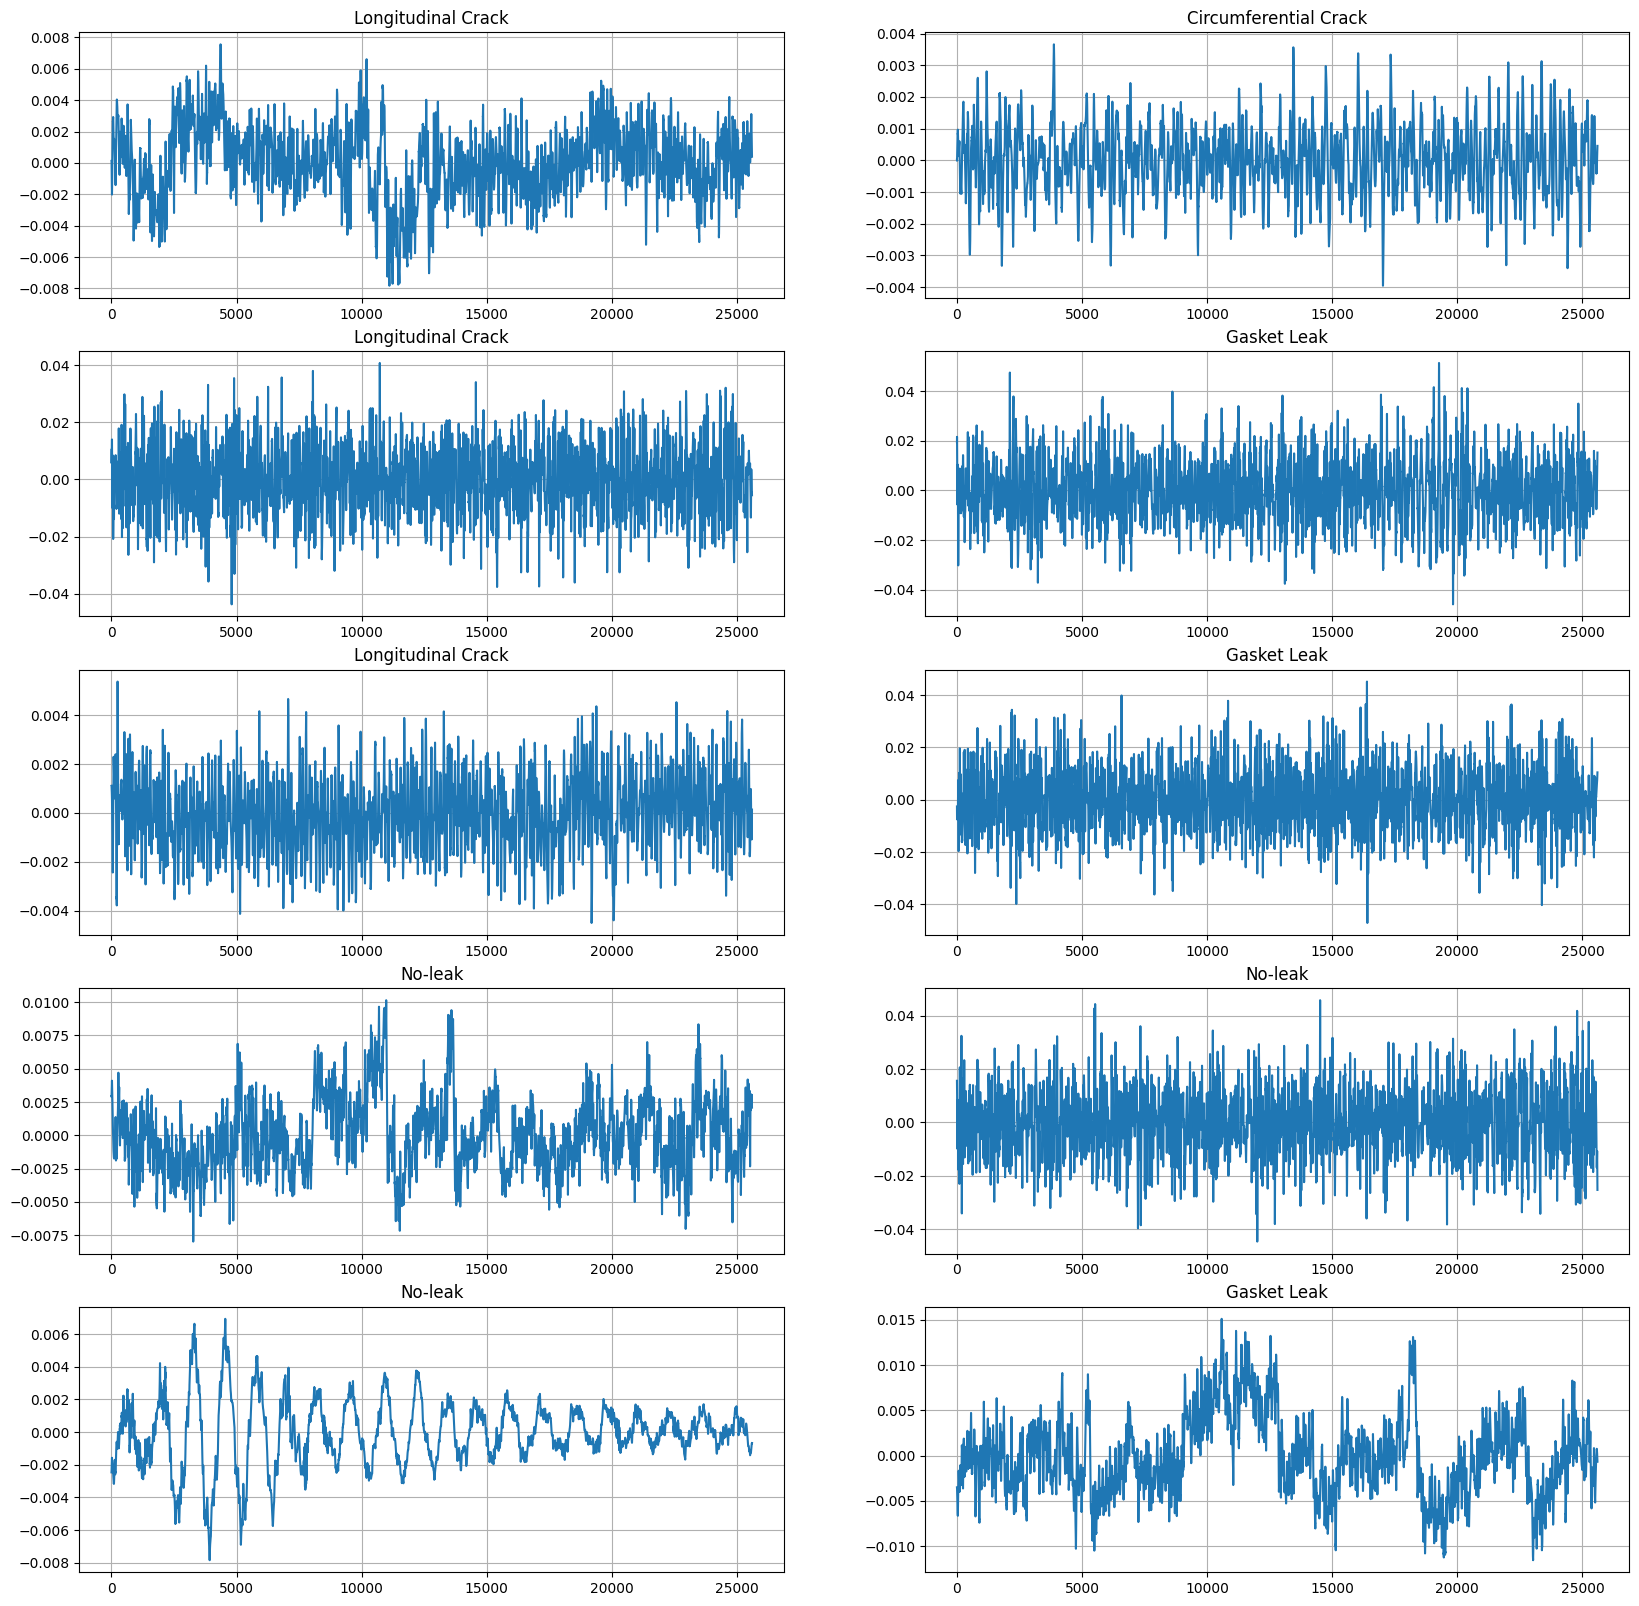

In [6]:
def wavelet_denoise(signals_dict, labels_dict):
    """
    Normaliza y aplica denoising wavelet a las señales

    Args:
        signals_dict: Diccionario con señales de entrenamiento y prueba
        labels_dict: Diccionario con etiquetas de entrenamiento y prueba

    Returns:
        wavelet_denoised_signals: Diccionario con señales procesadas
        labels_dict: Diccionario con etiquetas
    """
    # Crear un objeto de la clase WaveletDenoising
    wd = WaveletDenoising(normalize=True,
                      wavelet='sym3',
                      level=4,
                      thr_mode='soft',
                      method="universal")

    # Crear un nuevo diccionario para almacenar los coeficientes calculados:
    wavelet_denoised_signals = {'training': [], 'testing': []}

    for key, signals_subset in signals_dict.items():
        for signal_element in tqdm(signals_subset, desc=f"Denoising {key} signals"):
            # Denoising de la señal usando el método wavelet denoising
            denoised_signal = wd.fit(signal_element)

            # Almacenar las señales denoised en el nuevo diccionario
            wavelet_denoised_signals[key].append(denoised_signal)

    return wavelet_denoised_signals, labels_dict

# Denoising de las señales en los diccionarios de entrenamiento y prueba
wavelet_denoised_signals_dict, labels_dict = wavelet_denoise(signals_dict=signals_dict, labels_dict=labels_dict)

# Imprimir información sobre el dataset resultante:
print(f'Number of signals (training, testing): ({len(wavelet_denoised_signals_dict["training"])}, {len(wavelet_denoised_signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(wavelet_denoised_signals_dict["training"][0])}')

# Graficar algunas de las señales resultantes
plt.figure(figsize=(20, 20))
rows = 5
cols = 2
n = rows * cols

for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.plot(wavelet_denoised_signals_dict['training'][random_index[i]])

    # Obtener el nombre de la etiqueta según el modo de clasificación
    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.title(label_name)
    plt.grid()

 ## 4. Generación de Espectrogramas Logarítmicos mediante STFT

Generating spectrograms for testing: 100%|██████████| 240/240 [00:00<00:00, 555.58it/s]


Number of spectrograms (training, testing): (960, 240)
Spectrogram shape: (257, 101)


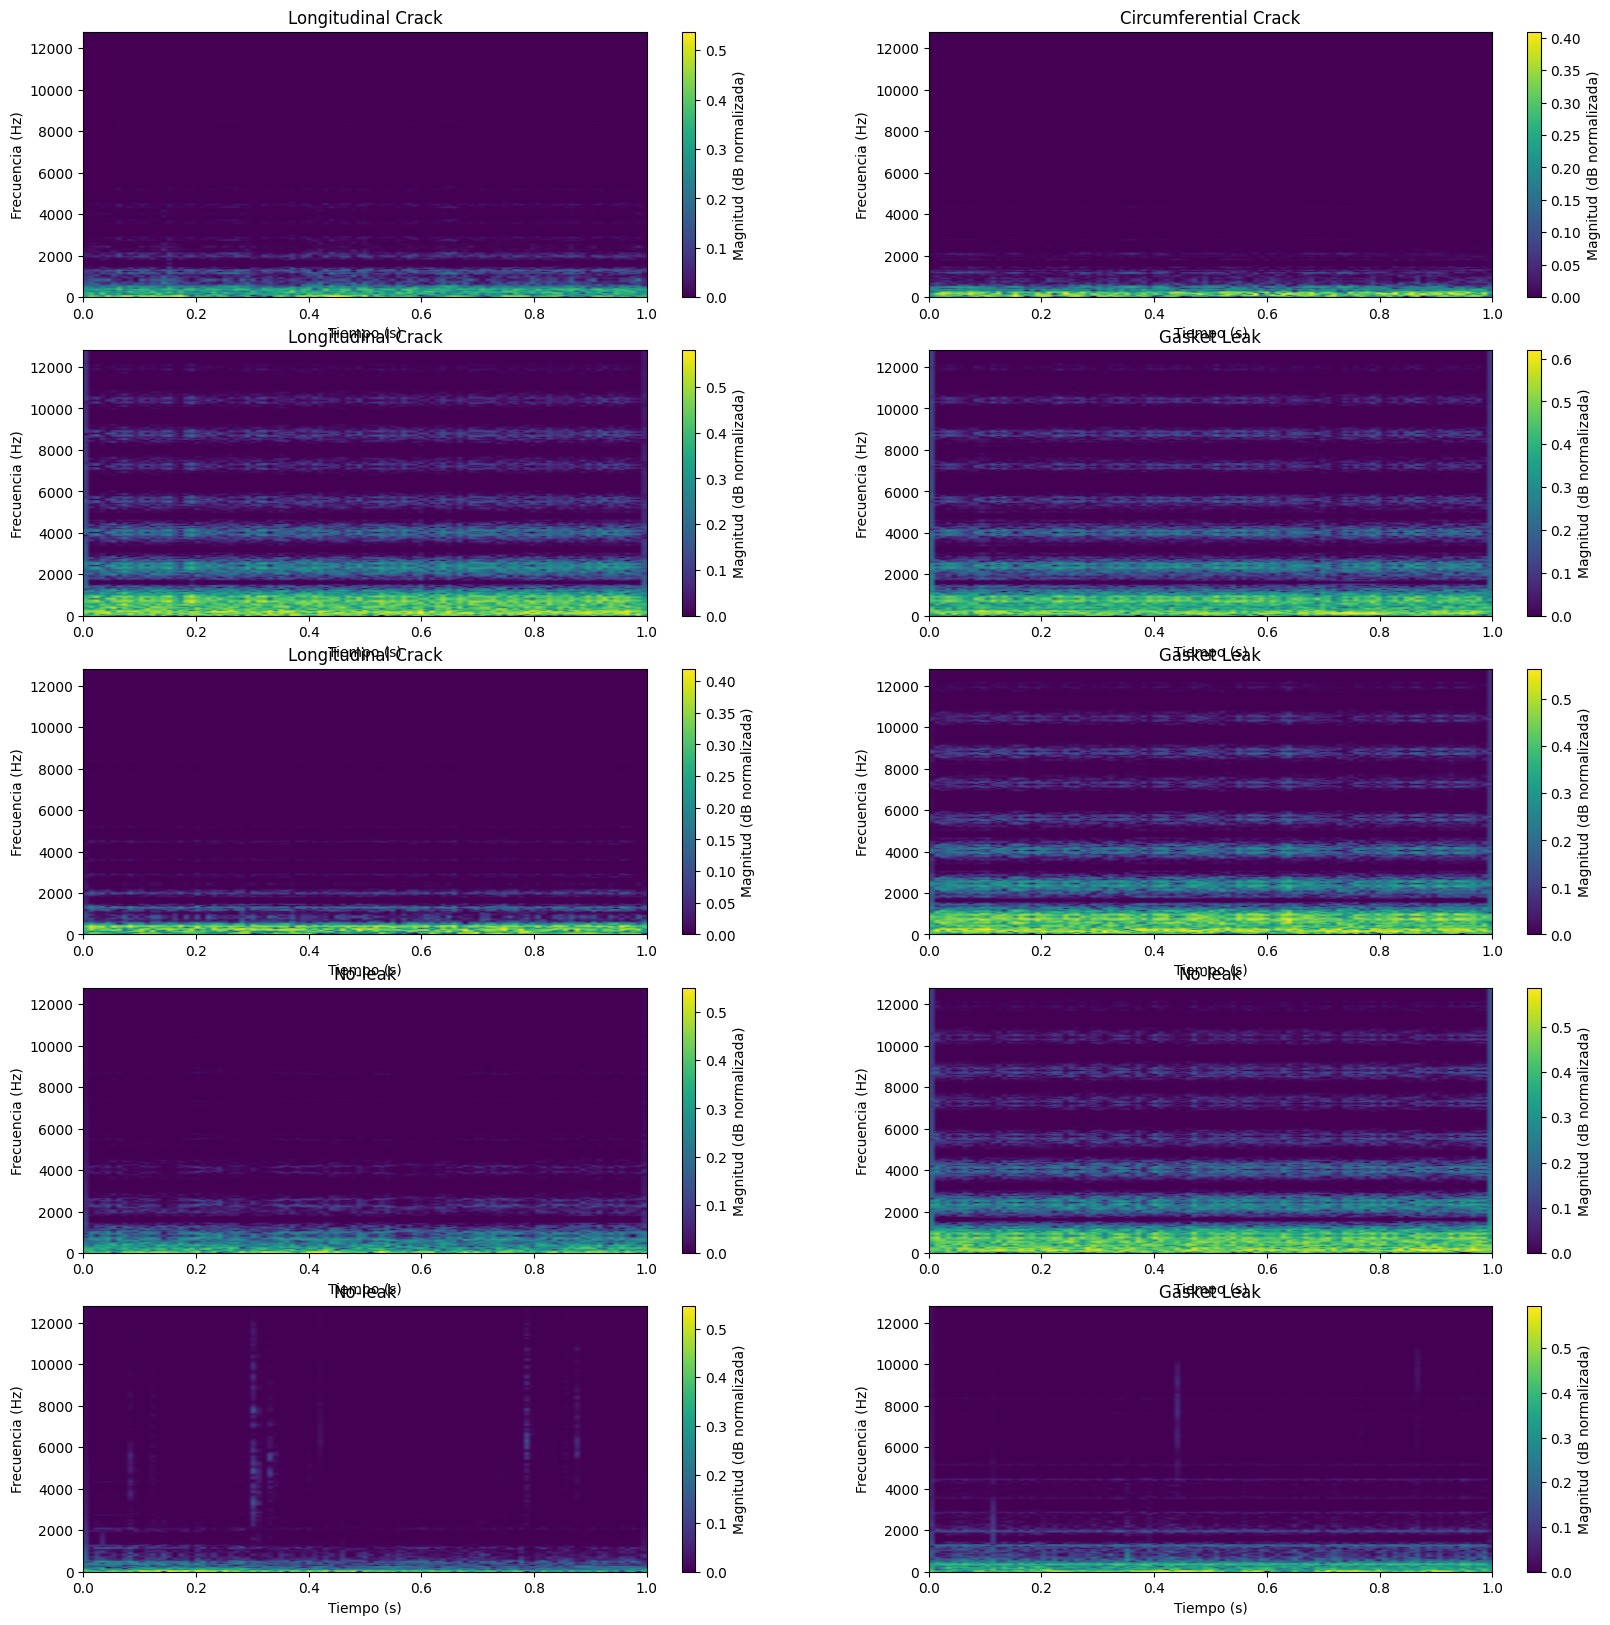

In [7]:
def generate_log_spectrograms(signals_dict, labels_dict, fs=25600):
    """
    Genera espectrogramas logarítmicos usando STFT

    Args:
        signals_dict: Diccionario con señales de entrenamiento y prueba
        labels_dict: Diccionario con etiquetas
        fs: Frecuencia de muestreo en Hz

    Returns:
        spectrograms_dict: Diccionario con espectrogramas
        labels_dict: Diccionario con etiquetas
    """
    # Parámetros para STFT adaptados a nuestra frecuencia de muestreo (25.6kHz vs 8kHz del paper)
    # Frame length: 20ms × 25.6kHz = 512 muestras
    # Frame shift: 10ms × 25.6kHz = 256 muestras
    frame_length = int(0.02 * fs)  # 20 ms
    frame_shift = int(0.01 * fs)  # 10 ms
    nfft = 512  # Tamaño de FFT como se especificó

    # Crear diccionario para almacenar espectrogramas
    spectrograms_dict = {'training': [], 'testing': []}

    # Verificar si es necesario eliminar frames con ruido de alta energía
    apply_denoising = False

    # Umbral para identificar frames con ruido (ajustar según sea necesario)
    mean_threshold = 0.7
    std_threshold = 0.5

    for key, signals_subset in signals_dict.items():
        for i, signal in enumerate(tqdm(signals_subset, desc=f"Generating spectrograms for {key}")):
            # Aplicar STFT
            f, t, Zxx = scipy.signal.stft(
                signal,
                fs=fs,
                window='hann',
                nperseg=frame_length,
                noverlap=frame_length-frame_shift,
                nfft=nfft
            )

            # Calcular espectrograma de potencia (magnitud al cuadrado)
            power_spectrogram = np.abs(Zxx)**2

            if apply_denoising:
                # Identificar frames con ruido de alta energía
                frame_means = np.mean(power_spectrogram, axis=0)
                frame_stds = np.std(power_spectrogram, axis=0)

                # Normalizar para obtener valores relativos
                norm_means = frame_means / np.max(frame_means)
                norm_stds = frame_stds / np.max(frame_stds)

                # Identificar frames ruidosos que superan los umbrales
                noisy_frames = (norm_means > mean_threshold) | (norm_stds > std_threshold)

                # Procesar frames ruidosos
                for j, is_noisy in enumerate(noisy_frames):
                    if is_noisy:
                        # Obtener el espectro del frame actual
                        frame_spectrum = power_spectrogram[:, j]

                        # Reemplazar valores de baja frecuencia (< 300Hz) que podrían contener ruido de baja frecuencia
                        low_freq_bins = int(300 / (fs/2) * (nfft//2))
                        frame_spectrum[:low_freq_bins] = np.mean(frame_spectrum[:low_freq_bins]) * 0.1

                        # Encontrar los picos locales (1-2 picos)
                        # Usamos una ventana de 10 bins para encontrar máximos locales
                        from scipy.signal import find_peaks
                        peaks, _ = find_peaks(frame_spectrum, distance=10)

                        if len(peaks) > 0:
                            # Crear una nueva versión del espectro con solo los picos principales
                            new_spectrum = np.zeros_like(frame_spectrum)

                            # Tomar los 2 picos más grandes si hay suficientes
                            num_peaks_to_keep = min(2, len(peaks))
                            peak_indices = peaks[np.argsort(frame_spectrum[peaks])[-num_peaks_to_keep:]]

                            # Mantener valor solo en los picos y sus alrededores
                            for peak_idx in peak_indices:
                                window_size = 5  # Bins a mantener alrededor del pico
                                start_idx = max(0, peak_idx - window_size)
                                end_idx = min(len(frame_spectrum), peak_idx + window_size + 1)
                                new_spectrum[start_idx:end_idx] = frame_spectrum[start_idx:end_idx]

                            # Reemplazar el frame original
                            power_spectrogram[:, j] = new_spectrum

            # Convertir a escala logarítmica (dB), agregando un pequeño valor para evitar log(0)
            eps = 1e-10
            log_spectrogram = 10 * np.log10(power_spectrogram + eps)

            # Normalizar a un rango adecuado
            log_spectrogram = np.clip(log_spectrogram, -100, 0)  # Limitar valores mínimos
            log_spectrogram = (log_spectrogram + 100) / 100  # Normalizar a [0, 1]

            # Transponer para tener tiempo en el eje horizontal y frecuencia en el vertical
            # También invertir el eje de frecuencia para que las frecuencias bajas estén abajo
            #log_spectrogram = log_spectrogram.T

            # Almacenar en el diccionario
            spectrograms_dict[key].append(log_spectrogram)

    return spectrograms_dict, labels_dict

# Generar espectrogramas logarítmicos
spectrograms_dict, labels_dict = generate_log_spectrograms(
    wavelet_denoised_signals_dict,
    labels_dict,
    fs=signal_sr
)

# Imprimir información sobre los espectrogramas
print(f'Number of spectrograms (training, testing): ({len(spectrograms_dict["training"])}, {len(spectrograms_dict["testing"])})')
print(f'Spectrogram shape: {spectrograms_dict["training"][0].shape}')

# Visualizar algunos espectrogramas
plt.figure(figsize=(20, 20))
rows = 5
cols = 2
n = rows * cols

for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.imshow(spectrograms_dict['training'][random_index[i]], aspect='auto', origin='lower',
              extent=[0, 1, 0, signal_sr/2])

    # Obtener el nombre de la etiqueta según el modo de clasificación
    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.colorbar(label='Magnitud (dB normalizada)')
    plt.title(label_name)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Frecuencia (Hz)')

## 5. Preparación de Datos para el Modelo CNN

In [10]:
def prepare_data_for_model(spectrograms_dict, labels_dict, classification_mode):
    """
    Prepara los datos para el modelo CNN

    Args:
        spectrograms_dict: Diccionario con espectrogramas
        labels_dict: Diccionario con etiquetas
        classification_mode: Modo de clasificación ('five_classes' o 'binary')

    Returns:
        x_train, y_train, x_test, y_test: Datos preparados para entrenamiento
        num_classes: Número de clases
    """
    # Convertir a arrays numpy
    x_train = np.array(spectrograms_dict['training'])
    y_train = np.array(labels_dict['training'])
    x_test = np.array(spectrograms_dict['testing'])
    y_test = np.array(labels_dict['testing'])

    # Normalizar entre -1 y 1
    x_train = (x_train - 0.5) * 2  # Escalar a [-1, 1]
    x_test = (x_test - 0.5) * 2  # Escalar a [-1, 1]

    # Expandir dimensión para canal (necesario para CNN)
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)

    # Determinar número de clases según el modo
    if classification_mode == 'five_classes':
        num_classes = 5
    else:  # binary
        num_classes = 2

    # One-hot encoding de las etiquetas
    y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)

    return x_train, y_train, y_train_onehot, x_test, y_test, y_test_onehot, num_classes
# Preparar los datos para el modelo
x_train, y_train, y_train_onehot, x_test, y_test, y_test_onehot, num_classes = prepare_data_for_model(
    spectrograms_dict,
    labels_dict,
    classification_mode
)

# Imprimir información sobre los datos preparados
print(f'x_train shape: {x_train.shape}')
print(f'y_train_onehot shape: {y_train_onehot.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test_onehot shape: {y_test_onehot.shape}')
print(f'Number of classes: {num_classes}')

# Guardar en formato HDF5
def save_dataset_to_h5(x_train, y_train, y_train_onehot, x_test, y_test, y_test_onehot,
                       classification_mode, num_classes, label_codes_dict,
                       file_path=None):
    """
    Guarda el dataset en formato HDF5
    """
    if file_path is None:
        file_path = f'/content/drive/MyDrive/Tesis/Accelerometer_Dataset/log_spectrogram_dataset_{classification_mode}.h5'

    print(f"Guardando dataset en {file_path}...")
    with h5py.File(file_path, 'w') as hf:
        # Crear grupos para training y testing
        train_group = hf.create_group('train')
        test_group = hf.create_group('test')

        # Guardar espectrogramas y etiquetas procesados
        train_group.create_dataset('spectrograms', data=x_train)
        train_group.create_dataset('labels', data=y_train)
        train_group.create_dataset('labels_onehot', data=y_train_onehot)

        test_group.create_dataset('spectrograms', data=x_test)
        test_group.create_dataset('labels', data=y_test)
        test_group.create_dataset('labels_onehot', data=y_test_onehot)

        # Guardar metadatos
        metadata = hf.create_group('metadata')
        metadata.create_dataset('num_classes', data=num_classes)
        metadata.create_dataset('shape', data=np.array(x_train.shape[1:]))
        metadata.attrs['classification_mode'] = classification_mode

        # Guardar diccionario de etiquetas
        import json
        if classification_mode == 'five_classes':
            label_codes_json = json.dumps({k: int(v) for k, v in label_codes_dict.items()})
        else:  # binary
            label_codes_json = json.dumps({k: int(v) for k, v in {'Leak': 0, 'No-leak': 1}.items()})
        metadata.attrs['label_codes_dict'] = label_codes_json

    print(f"Dataset procesado y guardado en {file_path}")
    print(f"Datos de entrenamiento: {len(x_train)} muestras")
    print(f"Datos de prueba: {len(x_test)} muestras")

    # Verificar la existencia del archivo guardado
    if os.path.exists(file_path):
        print(f"Archivo guardado correctamente. Tamaño: {os.path.getsize(file_path) / (1024*1024):.2f} MB")
    else:
        print("Error: No se pudo guardar el archivo")

# Guardar el dataset
save_dataset_to_h5(
    x_train, y_train, y_train_onehot,
    x_test, y_test, y_test_onehot,
    classification_mode, num_classes, label_codes_dict
)

x_train shape: (960, 257, 101, 1)
y_train_onehot shape: (960, 5)
x_test shape: (240, 257, 101, 1)
y_test_onehot shape: (240, 5)
Number of classes: 5
Guardando dataset en /content/drive/MyDrive/Tesis/Accelerometer_Dataset/log_spectrogram_dataset_five_classes.h5...
Dataset procesado y guardado en /content/drive/MyDrive/Tesis/Accelerometer_Dataset/log_spectrogram_dataset_five_classes.h5
Datos de entrenamiento: 960 muestras
Datos de prueba: 240 muestras
Archivo guardado correctamente. Tamaño: 237.69 MB


In [11]:
def validate_data_range(data, data_name):
    """
    Valida que los datos estén en el rango [-1, 1]

    Args:
        data: Datos a validar (x_train o x_test)
        data_name: Nombre de los datos para imprimir en el mensaje
    """
    min_value = np.min(data)
    max_value = np.max(data)

    if min_value >= -1 and max_value <= 1:
        print(f"{data_name} está en el rango [-1, 1]")
    else:
        print(f"¡Advertencia! {data_name} no está completamente en el rango [-1, 1]")
        print(f"Valor mínimo: {min_value}, Valor máximo: {max_value}")

# Llamar a la función para validar los datos de entrenamiento y prueba
validate_data_range(x_train, "x_train")
validate_data_range(x_test, "x_test")

x_train está en el rango [-1, 1]
x_test está en el rango [-1, 1]


## 6. Implementación de BinaryNet con Larq

In [21]:
def build_small_binarynet_leak_detection(input_shape, num_classes=5):
    """
    Construye un modelo BinaryNet reducido para la detección de fugas, manteniendo:
    - Primera capa con pesos cuantizados a 8 bits (usando DoReFa)
    - Capas intermedias binarias con cuantización 'ste_sign'
    - Activación PReLU y optimizador Bop
    La arquitectura se reduce disminuyendo el número de filtros, usando kernels 3x3 y
    reemplazando la gran capa densa por GlobalAveragePooling.

    Args:
        input_shape: Forma de entrada (alto, ancho, canales)
        num_classes: Número de clases (5 o 2)

    Returns:
        model: Modelo compilado
    """
    # Configuración para capas binarias intermedias
    binary_kwargs = dict(
        input_quantizer="ste_sign",
        kernel_quantizer="ste_sign",
        kernel_constraint="weight_clip",
        use_bias=False
    )

    model = tf.keras.models.Sequential()

    # Primera capa: Convolución con pesos cuantizados a 8 bits (sin cuantización de activaciones)
    model.add(lq.layers.QuantConv2D(
        filters=16,
        kernel_size=3,
        padding='same',
        kernel_quantizer=lq.quantizers.DoReFa(k_bit=8, mode="weights"),  # Cuantización int8 para el kernel
        kernel_constraint="weight_clip",
        use_bias=False,
        input_shape=input_shape
    ))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.999, scale=False))
    model.add(tf.keras.layers.PReLU())

    # Segunda capa: Convolución binaria
    model.add(lq.layers.QuantConv2D(
        filters=16,
        kernel_size=3,
        padding='same',
        **binary_kwargs
    ))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.999, scale=False))
    model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Tercera capa: Convolución binaria con un poco más de filtros
    model.add(lq.layers.QuantConv2D(
        filters=32,
        kernel_size=3,
        padding='same',
        **binary_kwargs
    ))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.999, scale=False))
    model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # En lugar de aplanar y usar una capa densa muy grande, usamos GlobalAveragePooling
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    # Capa de salida: Capa densa binaria que produce el número de clases
    model.add(lq.layers.QuantDense(num_classes, **binary_kwargs))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.999, scale=False))
    model.add(tf.keras.layers.Activation('softmax'))

    # Compilar modelo con optimizador Bop (valores de γ y τ según el paper)
    model.compile(
        optimizer=lq.optimizers.Bop(1e-4, 1e-8),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Crear modelo según el modo de clasificación
input_shape = x_train.shape[1:]
num_classes = 5 if classification_mode == 'five_classes' else 2
model = build_small_binarynet_leak_detection(input_shape, num_classes)

# Mostrar resumen del modelo
lq.models.summary(model)


+sequential_8 stats---------------------------------------------------------------------------------------------------------+
| Layer                       Input prec.             Outputs  # 1-bit  # 8-bit  # 32-bit   Memory  1-bit MACs  32-bit MACs |
|                                   (bit)                          x 1      x 1       x 1     (kB)                          |
+---------------------------------------------------------------------------------------------------------------------------+
| quant_conv2d_15                       -  (-1, 257, 101, 16)        0      144         0     0.14           0      3737808 |
| batch_normalization_24                -  (-1, 257, 101, 16)        0        0        32     0.12           0            0 |
| p_re_lu_19                            -  (-1, 257, 101, 16)        0        0    415312  1622.31           ?            ? |
| quant_conv2d_16                       1  (-1, 257, 101, 16)     2304        0         0     0.28    59804928        

In [22]:
def apply_spectrogram_augmentation(spectrograms, labels):
    """
    Aplica aumentación de datos a espectrogramas.
    """
    augmented_spectrograms = []
    augmented_labels = []

    for i, spectrogram in enumerate(spectrograms):
        # Original
        augmented_spectrograms.append(spectrogram)
        augmented_labels.append(labels[i])

        # Desplazamiento de frecuencia
        freq_shift = np.roll(spectrogram, np.random.randint(-5, 5), axis=0)
        augmented_spectrograms.append(freq_shift)
        augmented_labels.append(labels[i])

        # Desplazamiento de tiempo
        time_shift = np.roll(spectrogram, np.random.randint(-10, 10), axis=1)
        augmented_spectrograms.append(time_shift)
        augmented_labels.append(labels[i])

        # Ruido Gaussiano
        noise = np.random.normal(0, 0.05, spectrogram.shape)
        noisy_spec = spectrogram + noise
        noisy_spec = np.clip(noisy_spec, 0, 1)
        augmented_spectrograms.append(noisy_spec)
        augmented_labels.append(labels[i])

    return np.array(augmented_spectrograms), np.array(augmented_labels)

# Preparar división de datos para entrenamiento y validación
from sklearn.model_selection import train_test_split

x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train,
    y_train,
    test_size=0.2,
    stratify=y_train,  # Mantener la proporción de clases
    random_state=42
)

# Aplicar data augmentation
augmented_x_train, augmented_y_train = apply_spectrogram_augmentation(x_train_final, y_train_final)
print(f"Tamaño original: {len(x_train_final)}, Tamaño aumentado: {len(augmented_x_train)}")

# One-hot encoding de las etiquetas
augmented_y_train_onehot = tf.keras.utils.to_categorical(augmented_y_train, num_classes)
y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)

Tamaño original: 768, Tamaño aumentado: 3072


In [24]:
# Definir esquema de warmup para la tasa de aprendizaje
def warmup_schedule(epoch, lr):
    warmup_epochs = 5
    init_lr = 1e-6
    target_lr = 0.0001  # Valor menor para Bop según las recomendaciones

    if epoch < warmup_epochs:
        return init_lr + (target_lr - init_lr) * epoch / warmup_epochs
    return lr

# Función para programar la tasa de aprendizaje de Bop
def bop_lr_schedule(epoch):
    initial_learning_rate = 0.0001
    decay_rate = 0.2
    decay_steps = 10 * len(augmented_x_train) // batch_size  # Pasos para el decaimiento (10 épocas)

    # Calcular la tasa de aprendizaje con decaimiento exponencial
    lr = initial_learning_rate * (decay_rate ** (epoch // decay_steps))
    return lr

# Obtener el optimizador Bop del modelo
bop_optimizer = None
for layer in model.layers:
    if isinstance(layer, lq.layers.QuantLayer):
        if isinstance(layer.kernel_quantizer, lq.quantizers.SteSign):
            bop_optimizer = layer.kernel_quantizer.optimizer  # Obtener el optimizador Bop
            break

# Callbacks para entrenamiento
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,  # Aumentamos la paciencia para redes binarias
        restore_best_weights=True
    ),
    # Reemplazar BopLearningRateScheduler con HyperparameterScheduler
    lq.callbacks.HyperparameterScheduler(
        schedule=bop_lr_schedule,  # Función de programación
        hyperparameter="learning_rate",  # Hiperparámetro a programar
        optimizer=bop_optimizer,  # Optimizador Bop
        update_freq="epoch",  # Actualizar por época
        verbose=1,  # Mostrar mensajes de actualización
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'/content/drive/MyDrive/Tesis/Models/binary_leak_detection_{classification_mode}.h5',
        monitor='val_accuracy',
        save_best_only=True
    ),
    tf.keras.callbacks.LearningRateScheduler(warmup_schedule)
]

AttributeError: module 'larq.callbacks' has no attribute 'BopLearningRateScheduler'